# Код для лабораторной работы №5 (упражнение №3)

### Импорт библиотек

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import datetime
import time
import os
import sys
import json
import csv
import nltk

from datetime import datetime, timedelta
from pathlib import Path
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

### Загрузка датасета и EDA

In [5]:
data_dir = Path("data")
file_name = "all_news_2025-12-23.csv"
file_path = data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['Publication Date'])
display(df)

,Website,Title,Author,Publication Date,Link,Picture Link,Category,Topic,Relevance
0,Gazeta.ru,Директор СВР Нарышкин: Навальный умер своей см...,Ева Вишневская,2024-03-05 23:58:55,http://www.gazeta.ru/politics/2024/03/05/18378...,http://img.gazeta.ru/files3/181/18378181/23.28...,Политика,Politics,1
1,Gazeta.ru,HGC: в Красном море повреждены четыре кабеля г...,Ева Вишневская,2024-03-05 22:20:54,http://www.gazeta.ru/tech/2024/03/05/18377935....,http://img.gazeta.ru/files3/295/18378295/AP223...,Технологии,Science and tech,1
2,Gazeta.ru,"""Госдеп сообщил о скорой отставке замгоссекрет...",Ева Вишневская,2024-03-05 20:48:31,http://www.gazeta.ru/politics/2024/03/05/18377...,http://img.gazeta.ru/files3/761/18377761/RIA_6...,Политика,Politics,1
3,Gazeta.ru,МУС впервые выдал ордера на арест российских в...,Ева Вишневская,2024-03-05 18:19:04,http://www.gazeta.ru/politics/2024/03/05/18377...,http://img.gazeta.ru/files3/383/18377383/2in1-...,Политика,Politics,1
4,Gazeta.ru,"""Кая Каллас показала свой завтрак после обвине...",Ева Вишневская,2024-03-05 18:47:34,http://www.gazeta.ru/politics/2024/03/05/18377...,http://img.gazeta.ru/files3/173/18377173/12323...,Политика,Politics,1
...,...,...,...,...,...,...,...,...,...
3214,TASS,В Одессе произошел взрыв,NaN,2025-12-22 20:59:08,https://tass.ru/proisshestviya/25991355,NaN,Происшествия,Accidents,4
3215,TASS,В Кайтагском районе Дагестана передали награды...,NaN,2025-12-22 20:57:53,https://tass.ru/obschestvo/25991339,https://cdn-media.tass.ru/fit/400x300_b2b00b17...,Общество,Society,4
3216,TASS,Российский рынок акций закрылся разнонаправлен...,NaN,2025-12-22 20:55:30,https://tass.ru/ekonomika/25991295,NaN,Экономика и бизнес,Economics,4
3217,TASS,Syria TV: в Алеппо два мирных жителей погибли ...,NaN,2025-12-22 20:51:57,https://tass.ru/proisshestviya/25991325,NaN,Происшествия,Accidents,4


In [12]:
print("1. Общая информация:")
print("-"*40)
print(df.info())
    
print("\n2. Статистика признаков:")
print("-"*40)
display(df.describe(include='all').T)
    
print("\n3. Пропуски в данных:")
print("-"*40)
missing_data = pd.DataFrame({
    'Количество': df.isnull().sum(),
    'Доля в процентах': (df.isnull().sum() / len(df)) * 100
}).sort_values('Количество', ascending=False)
  
display(missing_data[missing_data['Количество'] > 0])
    
print("\n4. Уникальные значения по признакам:")
print("-"*40)
unique_counts = {}
for col in df.columns:
    unique_counts[col] = df[col].nunique()
unique_df = pd.DataFrame({
    'Колонка': list(unique_counts.keys()),
    'Количество уникальных значений': list(unique_counts.values())
})
display(unique_df)

print("\n5. Статистика по категориям:")
print("-"*40)

print("\n5.1 Распределение по веб-сайтам:")
website_stats = df['Website'].value_counts()
print(f"Всего сайтов: {website_stats.shape[0]}")
display(website_stats)

print("\n5.2 Распределение по темам (Topic):")
topic_stats = df['Topic'].value_counts()
display(topic_stats)

print("\n5.3 Распределение релевантности (Relevance):")
relevance_stats = df['Relevance'].value_counts().sort_index()
display(relevance_stats)

print("\n5.4 Статистика релевантности:")
print(f"Средняя релевантность: {df['Relevance'].mean():.2f}")
print(f"Медианная релевантность: {df['Relevance'].median():.2f}")
print(f"Минимальная релевантность: {df['Relevance'].min()}")
print(f"Максимальная релевантность: {df['Relevance'].max()}")

print("\n5.5 Распределение по категориям (Category):")
category_stats = df['Category'].value_counts().head(15)
display(category_stats)

print("\n6. Временные характеристики:")
print("-"*40)

df['Date'] = df['Publication Date'].dt.date
df['Hour'] = df['Publication Date'].dt.hour
df['DayOfWeek'] = df['Publication Date'].dt.day_name()
df['Month'] = df['Publication Date'].dt.month_name()

print("\n6.1 Количество новостей по дням:")
daily_stats = df['Date'].value_counts().sort_index()
print(f"Период охвата: {daily_stats.index.min()} - {daily_stats.index.max()}")
print(f"Всего дней: {daily_stats.shape[0]}")
print(f"Среднее количество новостей в день: {daily_stats.mean():.1f}")

print("\n7. Статистика заголовков:")
print("-"*40)

df['Title_Length'] = df['Title'].apply(lambda x: len(str(x)))
df['Title_Word_Count'] = df['Title'].apply(lambda x: len(str(x).split()))

print(f"Средняя длина заголовка: {df['Title_Length'].mean():.1f} символов")
print(f"Максимальная длина: {df['Title_Length'].max()} символов")
print(f"Минимальная длина: {df['Title_Length'].min()} символов")
print(f"Среднее количество слов: {df['Title_Word_Count'].mean():.1f}")

1. Общая информация:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Website           3219 non-null   object        
 1   Title             3219 non-null   object        
 2   Author            3083 non-null   object        
 3   Publication Date  3219 non-null   datetime64[ns]
 4   Link              3219 non-null   object        
 5   Picture Link      2886 non-null   object        
 6   Category          3018 non-null   object        
 7   Topic             3219 non-null   object        
 8   Relevance         3219 non-null   int64         
 9   Date              3219 non-null   object        
 10  Hour              3219 non-null   int32         
 11  DayOfWeek         3219 non-null   object        
 12  Month             3219 non-null   object        
 13  Title_Length    

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Website,3219,6,Vedomosti.ru,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,3219,2993,The EU is happy to mug its own taxpayers after...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,3083,402,Ведомости,895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publication Date,3219,NaN,NaN,NaN,2025-10-24 15:45:32.686548736,2023-10-18 01:11:05,2025-10-20 00:11:22.500000,2025-12-09 09:29:02,2025-12-19 18:57:46,2025-12-23 00:52:06,NaN
Link,3219,2997,https://www.rt.com/news/629815-assange-nobel-p...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Picture Link,2886,2666,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,3018,79,Мнения,383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Topic,3219,9,Unknown,1633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance,3219.0,NaN,NaN,NaN,1.505126,1.0,1.0,1.0,1.0,5.0,1.042399
Date,3219,329,2025-12-22,415,NaN,NaN,NaN,NaN,NaN,NaN,NaN



3. Пропуски в данных:
----------------------------------------


,Количество,Доля в процентах
Picture Link,333,10.344828
Category,201,6.244175
Author,136,4.224915



4. Уникальные значения по признакам:
----------------------------------------


,Колонка,Количество уникальных значений
0,Website,6
1,Title,2993
2,Author,402
3,Publication Date,2976
4,Link,2997
5,Picture Link,2666
6,Category,79
7,Topic,9
8,Relevance,5
9,Date,329



5. Статистика по категориям:
----------------------------------------

5.1 Распределение по веб-сайтам:
Всего сайтов: 6


Website
Vedomosti.ru    2000
RT               600
Lenta.ru         412
RG               100
TASS             100
Gazeta.ru          7
Name: count, dtype: int64


5.2 Распределение по темам (Topic):


Topic
Unknown                1633
Economics               880
Politics                247
Culture                 172
Science and tech        158
Society                  70
Sport                    35
Accidents                13
Travels and tourism      11
Name: count, dtype: int64


5.3 Распределение релевантности (Relevance):


Relevance
1    2456
2     275
3     221
4     159
5     108
Name: count, dtype: int64


5.4 Статистика релевантности:
Средняя релевантность: 1.51
Медианная релевантность: 1.00
Минимальная релевантность: 1
Максимальная релевантность: 5

5.5 Распределение по категориям (Category):


Category
Мнения                                      383
Россия                                      382
Бизнес                                      121
Финансы / Банки                             115
Недвижимость / Коммерческая недвижимость    108
Новости                                     100
Поп-культура                                100
Политика / Международные отношения           96
Политика / Международные новости             81
Экономика / Макроэкономика и бюджет          77
Недвижимость / Жилая недвижимость            76
Бизнес / Торговля и услуги                   75
Менеджмент / Рынок труда                     71
Общество                                     66
Технологии / Интернет и digital              63
Name: count, dtype: int64


6. Временные характеристики:
----------------------------------------

6.1 Количество новостей по дням:
Период охвата: 2023-10-18 - 2025-12-23
Всего дней: 329
Среднее количество новостей в день: 9.8

7. Статистика заголовков:
----------------------------------------
Средняя длина заголовка: 61.7 символов
Максимальная длина: 132 символов
Минимальная длина: 9 символов
Среднее количество слов: 9.0


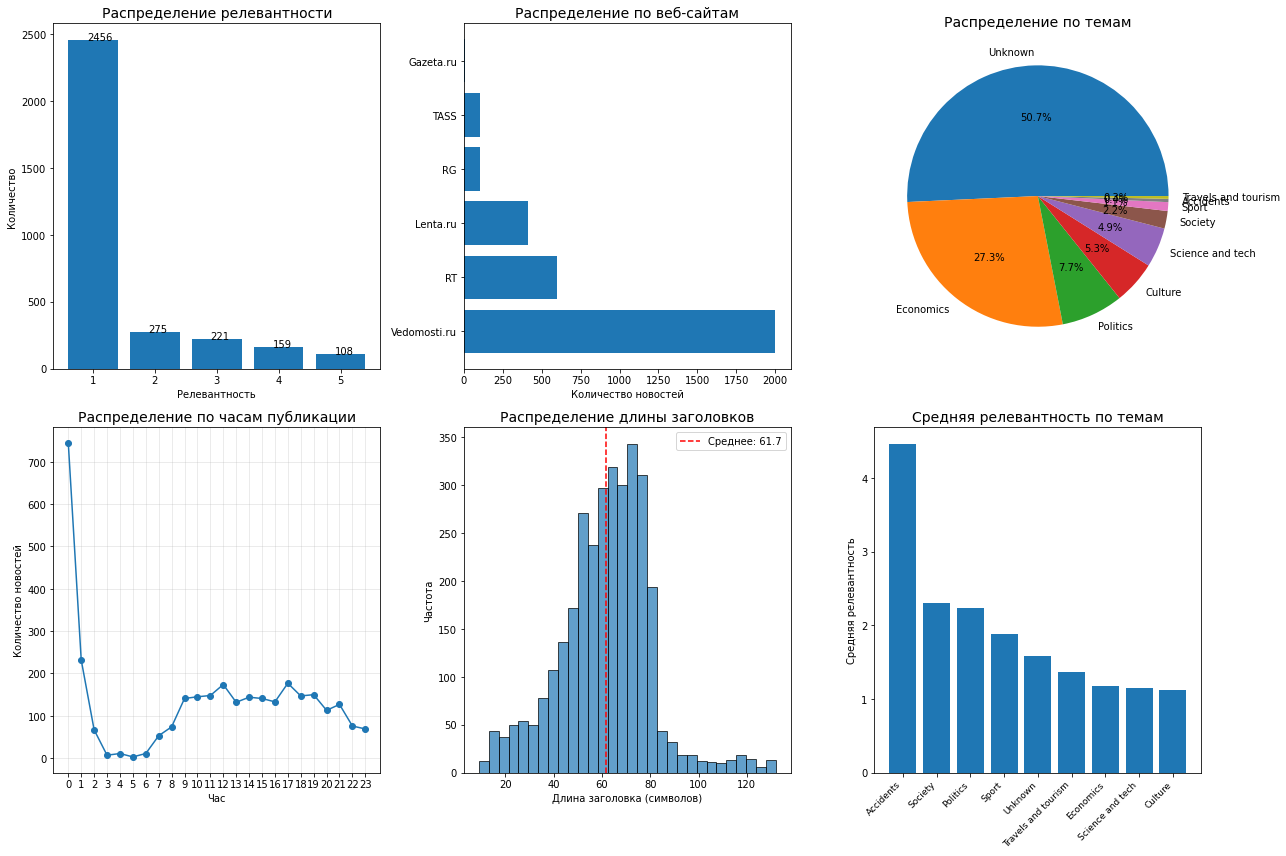

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].bar(df['Relevance'].value_counts().sort_index().index, 
               df['Relevance'].value_counts().sort_index().values)
axes[0, 0].set_title('Распределение релевантности', fontsize=14)
axes[0, 0].set_xlabel('Релевантность')
axes[0, 0].set_ylabel('Количество')
for i, v in enumerate(df['Relevance'].value_counts().sort_index().values):
    axes[0, 0].text(i+0.9, v + 0.5, str(v), fontsize=10)

top_websites = df['Website'].value_counts()
axes[0, 1].barh(range(len(top_websites)), top_websites.values)
axes[0, 1].set_yticks(range(len(top_websites)))
axes[0, 1].set_yticklabels(top_websites.index)
axes[0, 1].set_title('Распределение по веб-сайтам', fontsize=14)
axes[0, 1].set_xlabel('Количество новостей')

topics_counts = df['Topic'].value_counts()
axes[0, 2].pie(topics_counts.values, labels=topics_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Распределение по темам', fontsize=14)

hour_counts = df['Hour'].value_counts().sort_index()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o')
axes[1, 0].set_title('Распределение по часам публикации', fontsize=14)
axes[1, 0].set_xlabel('Час')
axes[1, 0].set_ylabel('Количество новостей')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['Title_Length'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Распределение длины заголовков', fontsize=14)
axes[1, 1].set_xlabel('Длина заголовка (символов)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(df['Title_Length'].mean(), color='red', linestyle='--', 
                  label=f'Среднее: {df["Title_Length"].mean():.1f}')
axes[1, 1].legend()

if 'Topic' in df.columns and 'Relevance' in df.columns:
    topic_relevance = df.groupby('Topic')['Relevance'].mean().sort_values(ascending=False)
    axes[1, 2].bar(range(len(topic_relevance)), topic_relevance.values)
    axes[1, 2].set_xticks(range(len(topic_relevance)))
    axes[1, 2].set_xticklabels(topic_relevance.index, rotation=45, ha='right')
    axes[1, 2].set_title('Средняя релевантность по темам', fontsize=14)
    axes[1, 2].set_ylabel('Средняя релевантность')
    axes[1, 2].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

Из интересного здесь можно заметить, что большинство новостей опубликовано больше чем 3 дня назад (судя по метрике релевантности), наибольшее количество новостей «опубликовано» в 0 часов 0 минут (хотя это по большей части из-за того, что при публикации был указан только день). Примерно половина новостей не размечена по категории - именно их и предстоит разметить с помощью обученной модели (и заодно пересчитать их релевантность)